# COMP90051 Project 2

In [125]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [126]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [145]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        # check whether narms is in the correct format (positive integer)
        self.narms = int(narms)
        if self.narms < 0:
            raise ValueError("\"narms\" should be a positive integer")
        
        # check whether epsilon is in the correct format (floating-point probability between 0 and 1)
        self.epsilon = float(epsilon)
        if self.epsilon < 0 or self.epsilon > 1:
            raise ValueError("\"epsilon\" should be a floating-point probability between 0 and 1")
        
        # check whether Q0 is in the correct format (real-valued value)
        self.Q0 = float(Q0)
            
        # initialize sum of rewards of each arm with Q0, appeard time of each arm with 0
        self.sum_rewards = np.full(self.narms, self.Q0)
        self.appear_times = np.zeros(self.narms)
        
    def play(self, tround, context=None):
        # with probability epsilon, return uniformly randomly choosed arm
        if (np.random.random_sample() < self.epsilon):
            return np.random.randint(self.narms)
        
        # else (probability 1-epsilon), return arm has maximum estimation value
        max_Qt_i, max_arms = 0, []
        
        # loop through all arms' estimation, find the arms have maximum estimation values
        for i in range(self.narms):
            if self.appear_times[i] > 0:
                Qt_i = self.sum_rewards[i] / self.appear_times[i]
            else:
                Qt_i = self.sum_rewards[i]
            
            if Qt_i > max_Qt_i:
                max_Qt_i = Qt_i
                max_arms = [i]
            elif Qt_i == max_Qt_i or abs(Qt_i - max_Qt_i) < 1e-6:
                max_arms.append(i)
        
        # if multiple arms have the maximum value, breaks the tie randomly
        return max_arms[np.random.randint(len(max_arms))] + 1
        
    def update(self, arm, reward, context=None):
        # check whether arm is positive integer between 1 and number of arms
        arm = int(arm) - 1
        if arm < 0 or arm >= self.narms:
            print(arm)
            raise ValueError("\"arm\" should be a positive integer between 1 and " + str(self.narms))
            
        # check whether reward is float
        reward = float(reward)
        
        # update sum of rewards and appeared times of this arm
        if self.appear_times[arm] > 0:
            self.sum_rewards[arm] += reward
            self.appear_times[arm] += 1
        else:
            self.sum_rewards[arm] = reward
            self.appear_times[arm] = 1
            
        return

In [146]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        # check whether narms is in the correct format (positive integer)
        self.narms = int(narms)
        if self.narms < 0:
            raise ValueError("\"narms\" should be a positive integer")
        
        # check whether rho is in the correct format (positive real value)
        self.rho = float(rho)
        if self.rho < 0:
            raise ValueError("\"rho\" should be a positive real value")
        
        # check whether Q0 is in the correct format (real-valued value)
        self.Q0 = float(Q0)
            
        # initialize sum of rewards of each arm with Q0, appeard time of each arm with 0
        self.sum_rewards = np.full(self.narms, self.Q0)
        self.appear_times = np.zeros(self.narms)

    def play(self, tround, context=None):
        max_Qt_i, max_arms = 0, []
        
        # check whether tround is in the correct format(positive integer)
        tround = int(tround)
        if tround < 0:
            raise alueError("\"tround\" should be a positive integer")
        
        # loop through all arms' estimation, find the arms have maximum estimation values
        for i in range(self.narms):
            if self.appear_times[i] > 0:
                Qt_i = self.sum_rewards[i] / self.appear_times[i] + np.sqrt(self.rho * np.log2(tround) / self.appear_times[i])
            else:
                Qt_i = self.sum_rewards[i]
            
            if Qt_i > max_Qt_i:
                max_Qt_i = Qt_i
                max_arms = [i]
            elif Qt_i == max_Qt_i or abs(Qt_i - max_Qt_i) < 1e-6:
                max_arms.append(i)
                
        # if multiple arms have the maximum value, breaks the tie randomly
        return max_arms[np.random.randint(len(max_arms))] + 1
        
    def update(self, arm, reward, context=None):
        # check whether arm is positive integer between 1 and number of arms
        arm = int(arm) - 1
        if arm < 0 or arm >= self.narms:
            raise ValueError("\"arm\" should be a positive integer between 1 and " + str(self.narms))
            
        # check whether reward is float
        reward = float(reward)
        
        # update sum of rewards and appeared times of this arm
        if self.appear_times[arm] > 0:
            self.sum_rewards[arm] += reward
            self.appear_times[arm] += 1
        else:
            self.sum_rewards[arm] = reward
            self.appear_times[arm] = 1
            
        return

## 2. The Basic Thompson Bandit

In [147]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        # check whether narms is in the correct format (positive integer)
        self.narms = int(narms)
        if self.narms < 0:
            raise ValueError("\"narms\" should be a positive integer")
            
        # check whether alpha0 is in the correct format (positive real value)
        self.alpha0 = float(alpha0)
        if self.alpha0 < 0.0:
            raise ValueError("\"alpha0\" should be a positive real value")
            
        # check whether beta0 is in the correct format (positive real value)
        self.beta0 = float(beta0)
        if self.beta0 < 0.0:
            raise ValueError("\"beta0\" should be a positive real value")
        
        # initialize Si and Fi, where Si is the posterior alpha update of arm i, 
        # Fi is the posterior beta update of arm i
        self.S = np.zeros(self.narms)
        self.F = np.zeros(self.narms)
    
    def play(self, tround, context=None):
        max_theta_i, max_arms = 0, []
        
        # loop through all arms' estimation, find the arms have maximum estimation values
        for i in range(self.narms):
            theta_i = np.random.beta(self.alpha0 + self.S[i], self.beta0 + self.F[i])
            
            if theta_i > max_theta_i:
                max_theta_i = theta_i
                max_arms = [i]
            elif theta_i == max_theta_i or abs(theta_i - max_theta_i) < 1e-6:
                max_arms.append(i)
                
        # if multiple arms have the maximum value, breaks the tie randomly
        return max_arms[np.random.randint(len(max_arms))] + 1
        
    def update(self, arm, reward, context=None):
        # check whether arm is positive integer between 1 and number of arms
        arm = int(arm) - 1
        if arm < 0 or arm >= self.narms:
            raise ValueError("\"arm\" should be a positive integer between 1 and " + str(self.narms))
            
        # check whether reward is an int
        reward = int(reward)      
        
        # for arm i, increment S_i (update of alpha0) if the reward is 1, 
        # F_i (update of beta0) if the reward is 0
        if reward == 0:
            self.F[arm] += 1
        elif reward == 1:
            self.S[arm] += 1
        # reward value not valid (neither 0 nor 1), raise exception
        else:
            raise ValueError("\"reward\" should be a positive integer has value either 0 or 1")
        
        return

## 3. Off-Policy Evaluation

In [148]:
# Read dataset and transformed into suitable format: arms, rewards and contexts
DATASET = "../resources/data/dataset.txt"

arms, rewards, contexts = [], [], []
data_file = open(DATASET, 'r')
for line in data_file:
    cols = line.lstrip().rstrip().split(' ')
    
    arms.append(cols[0])
    rewards.append(cols[1])
    contexts.append(cols[2:])
    
arms = np.array(arms, dtype="int32")
rewards = np.array(rewards, dtype="float64")
contexts = np.array(contexts, dtype="float64")

In [149]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    # check whether arms, rewards and contexts have the same length
    if len(arms) != len(rewards) or len(arms) != len(contexts) or len(rewards) != len(contexts):
        raise ValueError("\"arms\", \"rewards\", and \"contexts\" should have the same length")
    
    # check whether nrounds is in the correct format (positive integer)
    nrounds = int(nrounds)
    if nrounds < 0:
        raise ValueError("\"nrounds\" should be a positive integer")
        
    # initialize R, where R contains rewards of all retained events. h parameter used in the literature to store
    # all historial retained events is not used anywhere in this type of implementation (these historical 
    # information is actually stored inside of MAB), thus not stored.
    R = []
    
    # loop through streams, until reach the end of stream or retain enough events and rewards (specified by nrounds)
    for i in range(len(arms)):
        # check whether arm is in the correct format (positive integer between 1 and mab.narms)
        arm = int(arms[i])
        if arm < 1 or arm > mab.narms:
            raise ValueError("\"arm\" should be a positive integer between 1 and " + str(self.narms))
        
        # check whether reward is in the correct format (float)
        reward = float(rewards[i])
    
        # check whether context is in the correct format (number of col equals to a positive multiple of mab.narms, and datatypes is float)
        context = np.array(contexts[i], dtype="float64")
        if len(context) % mab.narms != 0:
            raise ValueError("\"context\" should have number of columns equal to a positive multiple of mab.narms")
        
        # If the MAB chooses the same arm as the current one, retain the event, update R and MAB
        # Else do nothing
        if mab.play(tround=len(R)+1, context=contexts[i]) == arm:
            mab.update(arm=arm, reward=reward, context=contexts[i])
            R.append(reward)
        
        # Stop looping if retained enough events/rewards
        if nrounds != None and len(R) >= nrounds:
            break
        
        # Reach the end of stream but didn't retain enough events, print out warning to users
        if i == len(arms)-1 and nrounds != None:
            print("####Warning: reach the end of stream without retaining enough events, actual number of event: " + len(R))
    
    return R

In [150]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.26125


In [151]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.15875


In [152]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.1975


## 4. Contextual Bandits - LinUCB

In [163]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        # check whether narms is in the correct format (positive integer)
        self.narms = int(narms)
        if self.narms < 0:
            raise ValueError("\"narms\" should be a positive integer")
            
        # check whether ndims is in the correct format (positive integer)
        self.ndims = int(ndims)
        if self.ndims < 0:
            raise ValueError("\"ndims\" should be a positive integer")
        
        # check whether alpha is in the correct format (positive real value)
        self.alpha = float(alpha)
        if self.alpha < 0:
            raise ValueError("\"alpha\" should be a positive real value")
        
        # initialize A and b of size self.narms (create A_i and b_i for each arm i), where
        # A_i is initialized as d-dimensional identity matrix, and b_i is initialized as d-dimensional zero vector
        # Q_i is the inverse of A_i calculated to decrease computation cost
        A, Q, b = [], [], []
        for i in range(self.narms):
            A.append(np.identity(self.ndims))
            Q.append(np.identity(self.ndims))
            b.append(np.zeros(self.ndims))
            
        self.A = np.array(A)
        self.Q = np.array(Q)
        self.b = np.array(b)
        
    def play(self, tround, context):
        # check whether tround is in the correct format(positive integer)
        tround = int(tround)
        if tround < 0:
            raise alueError("\"tround\" should be a positive integer")
            
        # check whether context is in the correct format (dimension: self.ndims * self.narms)
        context = np.array(context, dtype="float64")
        if len(context) != self.ndims * self.narms:
            raise ValueError("\"context\" should have number of columns equal to self.ndims * self.narms")
        
        max_p_i, max_arms = 0, []
        
        # loop through all arms' estimation, find the arms have maximum estimation values
        for i in range(self.narms):
            # obtain the features corresponding to this arm
            x_i = context[i*self.ndims:(i+1)*self.ndims]
            
            theta_hat_i = np.dot(self.Q[i], self.b[i])
            p_i = np.dot(theta_hat_i.T, x_i) + self.alpha * np.sqrt(np.dot(np.dot(x_i.T, self.Q[i]), x_i))
            
            if p_i > max_p_i:
                max_p_i = p_i
                max_arms = [i]
            elif p_i == max_p_i or abs(p_i - max_p_i) < 1e-6:
                max_arms.append(i)
        
        # if multiple arms have the maximum value, breaks the tie randomly
        return max_arms[np.random.randint(len(max_arms))] + 1
    
    def update(self, arm, reward, context):
        # check whether arm is positive integer between 1 and number of arms
        arm = int(arm) - 1
        if arm < 0 or arm >= self.narms:
            raise ValueError("\"arm\" should be a positive integer between 1 and " + str(self.narms))
            
        # check whether reward is a float
        reward = float(reward)
            
        # check whether context is in the correct format (dimension: self.ndims * self.narms, dtype: float)
        context = np.array(context, dtype="float64")
        if len(context) != self.ndims * self.narms:
            raise ValueError("\"context\" should have number of columns equal to self.ndims * self.narms")
        
        # obtain the features corresponding to this arm
        x_i = context[arm*self.ndims:(arm+1)*self.ndims]
        
        # update correspond A_i, Q_i and b_i
        self.A[arm] += np.dot(x_i, x_i.T)
        self.Q[arm] = np.linalg.inv(self.A[arm])
        self.b[arm] += np.dot(reward, x_i)
        
        return

In [164]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.2675


## 5. Contextual Bandits - LinThompson

In [168]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        # check whether narms is in the correct format (positive integer)
        self.narms = int(narms)
        if self.narms < 0:
            raise ValueError("\"narms\" should be a positive integer")
            
        # check whether ndims is in the correct format (positive integer)
        self.ndims = int(ndims)
        if self.ndims < 0:
            raise ValueError("\"ndims\" should be a positive integer")
        
    def play(self, tround, context):
        return 0
    
    def update(self, arm, reward, context):
        return

In [170]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

## 6. Evaluation
### 6.A.

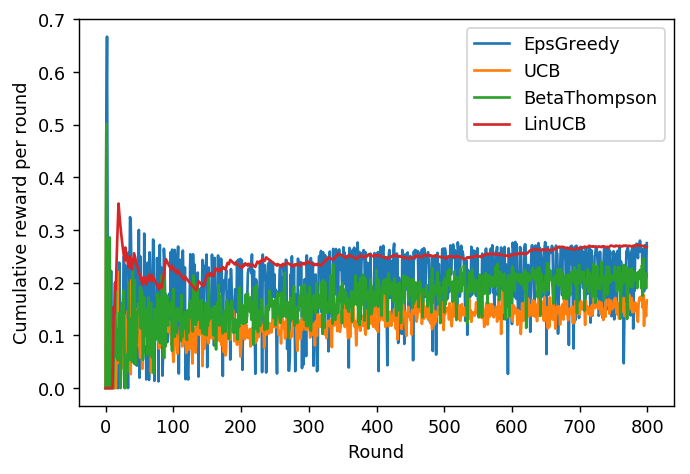

In [172]:
# plot the running per-round cumulative reward over round from MIN_ROUND to MAX_ROUND, for all 5 different MABs above
MIN_ROUND = 1
MAX_ROUND = 800

# obtain results from 5 MABs
results = {"EpsGreedy":[], "UCB":[], "BetaThompson":[], "LinUCB":[]} #, "LinThompson":[]}
for i in range(MIN_ROUND, MAX_ROUND+1):
    mab = EpsGreedy(10, 0.05)
    results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, i)
    results["EpsGreedy"].append(np.mean(results_EpsGreedy))
    
    mab = UCB(10, 1.0)
    results_UCB = offlineEvaluate(mab, arms, rewards, contexts, i)
    results["UCB"].append(np.mean(results_UCB))
    
    mab = BetaThompson(10, 1.0, 1.0)
    results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, i)
    results["BetaThompson"].append(np.mean(results_BetaThompson))
    
    mab = LinUCB(10, 10, 1.0)
    results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, i)
    results["LinUCB"].append(np.mean(results_LinUCB))
    '''
    mab = LinThompson(10, 10, 1.0)
    results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, i)
    results["LinThompson"].append(np.mean(results_LinThompson))
    '''
    print("####INFO: progress " + "{0:.0%}".format(i / (MAX_ROUND+1-MIN_ROUND)), end='\r')
    
# plot the results
plt.rcParams["figure.dpi"] = 128
plt.plot(results["EpsGreedy"], label="EpsGreedy")
plt.plot(results["UCB"], label="UCB")
plt.plot(results["BetaThompson"], label="BetaThompson")
plt.plot(results["LinUCB"], label="LinUCB")
# plt.plot(results["LinThompson"], label="LinThompson")
plt.xlabel("Round")
plt.ylabel("Cumulative reward per round")
plt.legend()

### 6.B.